### First, we get mnist data.

In [3]:
from oreilly.dataset.mnist import load_mnist
import numpy as np

In [12]:
mnist = load_mnist()

### Execution Part

In [52]:
def run(gamma, proto_n, criti_n, ktype):

    digitsdat = Data()
    digitsdat.X = mnist[0][0][:5000]
    digitsdat.y = mnist[0][1][:5000]
    digitsdat.gamma = gamma
    
    if ktype == 0:
        digitsdat.calculate_kernel()
        print("Running Kernel type : global ")
    else:
        digitsdat.calculate_kernel_individual()
        print("Running Kernel type : local ")

    selected = greedy_select_protos(digitsdat.kernel, np.array(range(np.shape(digitsdat.kernel)[0])), proto_n)
    selectedy = digitsdat.y[selected]
    sortedindx = np.argsort(selectedy)

    critselected = None

    if criti_n > 0:
        critselected = select_criticism_regularized(digitsdat.kernel, selected, criti_n, is_K_sparse=False, reg='logdet')

        critselectedy = digitsdat.y[critselected]
        critsortedindx = np.argsort(critselectedy)

    return selected, critselected, digitsdat

# mnistを並べて表示する
def plot(selected,data):
    # データの表示
    W = 10  # 横に並べる個数
    H = 10   # 縦に並べる個数
    
    fig = plt.figure(figsize=(H, W))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.05, wspace=0.05)
    
    for i in range(W*H):
        ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
        ax.imshow(data[selected[i]].reshape((28, 28)))

    plt.show()

Running Kernel type : local 
Prototypes


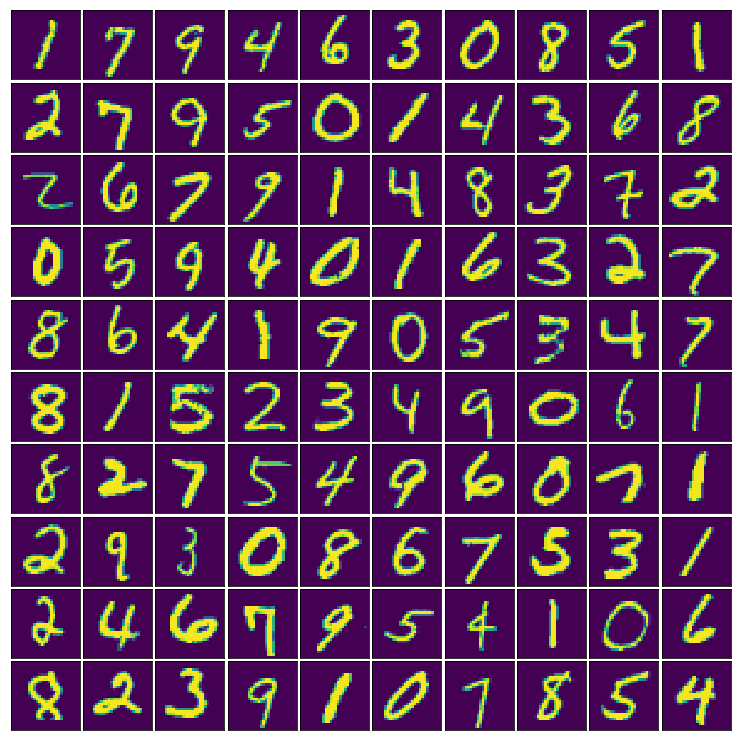

Criticisms


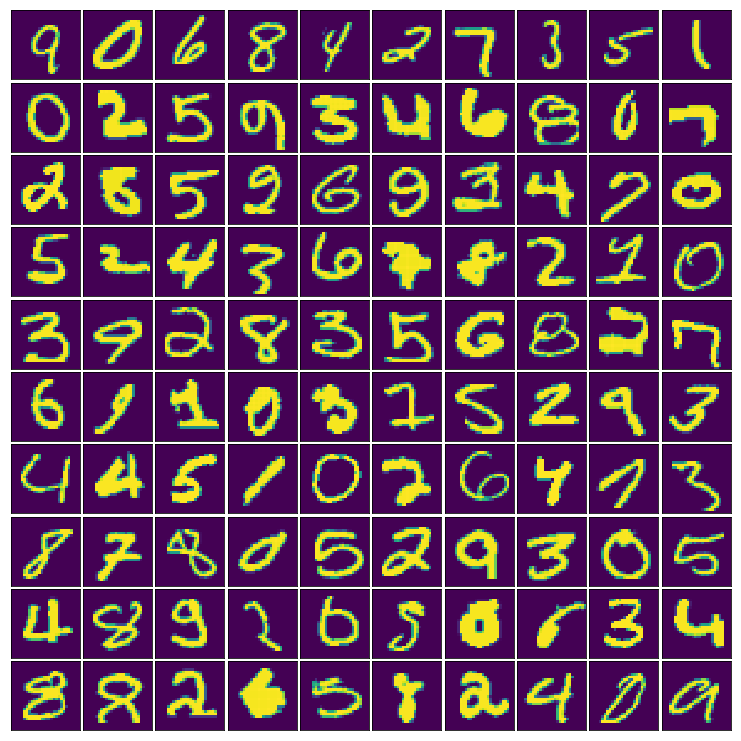

...done


In [53]:
def main(gamma,prototypes_num,kerneltype):

    criticisms_num = 100 # number of criticisms

    selected, critselected, digitsdat = run(gamma,prototypes_num,criticisms_num,kerneltype)

    print("Prototypes")
    plot(selected,digitsdat.X)

    print("Criticisms")
    plot(critselected,digitsdat.X)

    print("...done")

if __name__ == '__main__':
    gamma = 0.026                                 # kernel parameter, obtained after cross validation
    prototypes_num = 410                          # total number of prototypes to select
    kernel_type = 1                               # 1 for local, 0 for global
    main(gamma, prototypes_num,kernel_type)      # execution

<br>

## Code below is from original code I mentioned at README.md.  
## But I deleted some methods that I don't use.
<br>

### Data Class (You can form kernel matrix using this class)

In [49]:
# maintained by rajivak@utexas.edu
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics.pairwise import rbf_kernel


# class to load and handle data
class Data:
    X = None # n * d
    y = None # n
    gamma = None
    kernel  = None # n* n

    def __init__(self):
        pass

    def calculate_kernel(self, g=None):
        if g is None:
            if self.gamma is None:
                print("gamma not provided!")
                exit(1)
            else:
                self.kernel = rbf_kernel(self.X, gamma=self.gamma)
        else:
            self.kernel = rbf_kernel(self.X, gamma=g)

    # only calculate distance within class. across class, distance = 0
    def calculate_kernel_individual(self, g=None):
        touseg = g
        if touseg is None:
            touseg = self.gamma
        if touseg is None:
            print("gamma not provided!")
            exit(1)
        self.kernel = np.zeros((np.shape(self.X)[0], np.shape(self.X)[0]) )
        sortind = np.argsort(self.y)
        self.X = self.X[sortind, :]
        self.y = self.y[sortind]

        for i in np.arange(-1,9):
            j = i+1
            ind = np.where(self.y == j)[0]
            startind = np.min(ind)
            endind = np.max(ind)+1
            self.kernel[startind:endind, startind:endind ] = rbf_kernel(self.X[startind:endind, :], gamma=self.gamma)

<br><br>
### func for MMD-critic Selection

In [50]:
# maintained by rajivak@utexas.edu
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
# from mpi4py import MPI
import sys
import math
import matplotlib.pyplot as plt

##############################################################################################################################
# function to select criticisms
# ARGS:
# K: Kernel matrix
# selectedprotos: prototypes already selected
# m : number of criticisms to be selected
# reg: regularizer type.
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: indices selected as criticisms
##############################################################################################################################
def select_criticism_regularized(K, selectedprotos, m, reg='logdet', is_K_sparse=True):

    n = np.shape(K)[0]
    if reg in ['None','logdet','iterative']:
        pass
    else:
        print("wrong regularizer :" + reg)
        exit(1)
    options = dict()

    selected = np.array([], dtype=int)
    candidates2 = np.setdiff1d(range(n), selectedprotos)
    inverse_of_prev_selected = None  # should be a matrix

    if is_K_sparse:
        colsum = np.array(K.sum(0)).ravel()/n
    else:
        colsum = np.sum(K, axis=0)/n

    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(candidates2, selected)

        s1array = colsum[candidates]

        temp = K[selectedprotos, :][:, candidates]
        if is_K_sparse:
            s2array = temp.sum(0)
        else:
            s2array = np.sum(temp, axis=0)

        s2array = s2array / (len(selectedprotos))

        s1array = np.abs(s1array - s2array)
        if reg == 'logdet':
            if inverse_of_prev_selected is not None: # first call has been made already
                temp = K[selected, :][:, candidates]
                if is_K_sparse:
                    temp2 = temp.transpose().dot(inverse_of_prev_selected)
                    regularizer = temp.transpose().multiply(temp2)
                    regcolsum = regularizer.sum(1).ravel()# np.sum(regularizer, axis=0)
                    regularizer = np.abs(K.diagonal()[candidates] - regcolsum)

                else:
                    # hadamard product
                    temp2 = np.array(np.dot(inverse_of_prev_selected, temp))
                    regularizer = temp2 * temp
                    regcolsum = np.sum(regularizer, axis=0)
                    regularizer = np.log(np.abs(np.diagonal(K)[candidates] - regcolsum))
                s1array = s1array + regularizer
            else:
                if is_K_sparse:
                    s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
                else:
                    s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))
        argmax = candidates[np.argmax(s1array)]
        maxx = np.max(s1array)

        selected = np.append(selected, argmax)
        if reg == 'logdet':
            KK = K[selected,:][:,selected]
            if is_K_sparse:
                KK = KK.todense()

            inverse_of_prev_selected = np.linalg.inv(KK) # shortcut
        if reg == 'iterative':
            selectedprotos = np.append(selectedprotos, argmax)

    return selected

##############################################################################################################################
# Function choose m of all rows by MMD as per kernelfunc
# ARGS:
# K : kernel matrix
# candidate_indices : array of potential choices for selections, returned values are chosen from these  indices
# m: number of selections to be made
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: subset of candidate_indices which are selected as prototypes
##############################################################################################################################

def greedy_select_protos(K, candidate_indices, m, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    # colsum = np.array(K.sum(0)).ravel() # same as rowsum
    if is_K_sparse:
        colsum = 2*np.array(K.sum(0)).ravel() / n
    else:
        colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
    value = np.array([])
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        if len(selected) > 0:
            temp = K[selected, :][:, candidates]
            if is_K_sparse:
                # s2array = temp.sum(0) *2
                s2array = temp.sum(0) * 2 + K.diagonal()[candidates]

            else:
                s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]

            s2array = s2array/(len(selected) + 1)

            s1array = s1array - s2array

        else:
            if is_K_sparse:
                s1array = s1array - (np.abs(K.diagonal()[candidates]))
            else:
                s1array = s1array - (np.abs(np.diagonal(K)[candidates]))

        argmax = candidates[np.argmax(s1array)]
        # print("max %f" %np.max(s1array))

        selected = np.append(selected, argmax)
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        if is_K_sparse:
            KK = KK.todense()

        inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected]
